In [5]:
!pip install maup

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for maup from https://files.pythonhosted.org/packages/fd/0a/d9619442c2ac5925692f3d25d46d671282668b0ed442a8ef798d0f81b1db/maup-2.0.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/42.7 kB ? eta -:--:--
   ---------------------------- ----------- 30.7/42.7 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 42.7/42.7 kB 690.9 kB/s eta 0:00:00


=========block boundaries as of 2020===============
EPSG:4269
=========demographic data al pl 2020===============
=========2020 Exo gen election data====================
============No of rows in voting data======= 54
============No of columns in voting data======= 28
=========block boundaries with census data===============
=========Checking the CRS========     True


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\maup\intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\maup\intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\maup\assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


=========block precinct assignment===============
=========aggregated census data===============
=======GEOID20=========
=========exogenous data with census data===============
okayyy===
$$$$$$$ Plotting Started for $$$==> White Population by Precinct
$$$$$$$ Plotting Started for $$$==> Black Population by Precinct


C:\Users\user\AppData\Local\Temp\ipykernel_16612\1649355673.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x= 'Candidate', y= 'Votes', data=melted_data,ci=None)


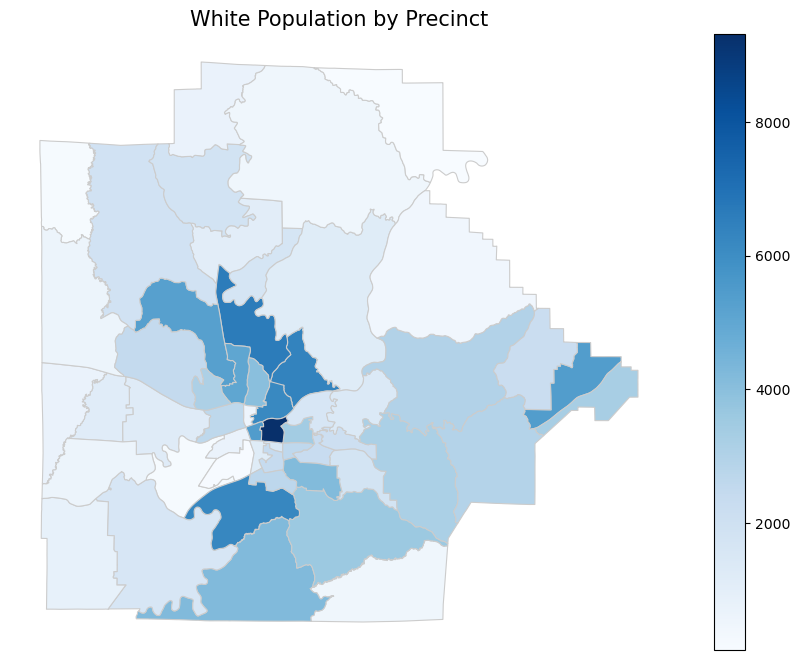

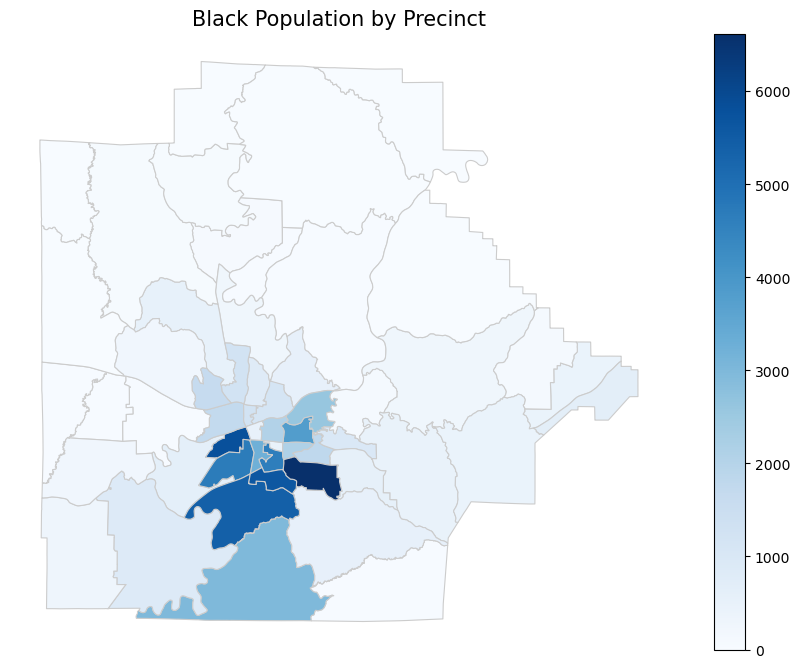

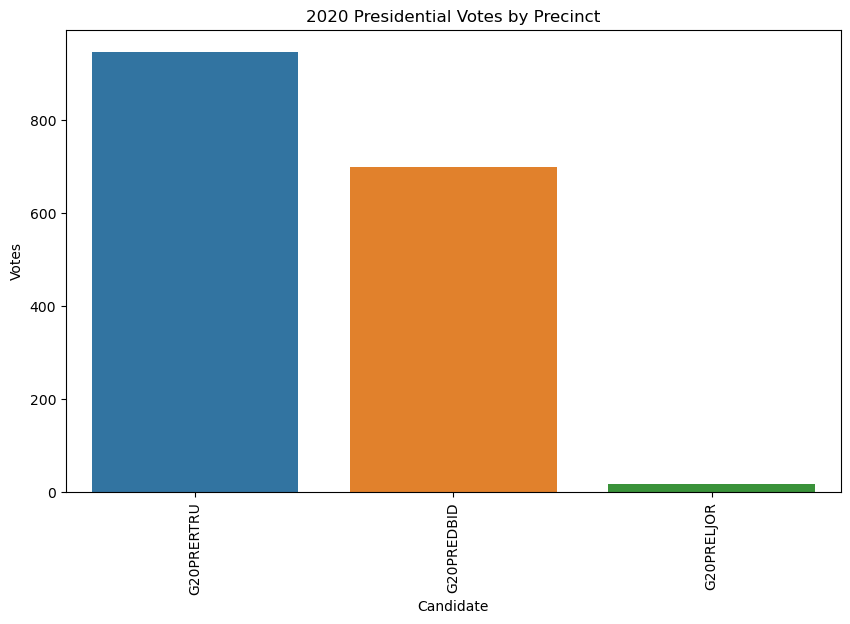

In [25]:
import geopandas as gpd
import pandas as pd
import maup

# loading the block shapefile
block_boundaries = gpd.read_file(r"D:\Upwork\Ecological inference statistical analysis\Data\rrep_assignment_tuscaloosa_al_files\rrep_assignment_tuscaloosa_al_files\tuscaloosa_al_block2020\tuscaloosa_al_block2020.shp")
block_boundaries ['GEOID20'] = block_boundaries['GEOID20'].astype(str)
block_boundaries.to_csv("block_boundaries.csv")

print("=========block boundaries as of 2020===============")
print(block_boundaries.crs)
# print(block_boundaries.head(5))

# Census Data
census_data_2020 = pd.read_csv(r"D:\Upwork\Ecological inference statistical analysis\Data\rrep_assignment_tuscaloosa_al_files\rrep_assignment_tuscaloosa_al_files\tuscaloosa_al_pl2020\tuscaloosa_al_pl2020.csv")
census_data_2020['GEOCODE'] = '0'+census_data_2020['GEOCODE'].astype(str)
print("=========demographic data al pl 2020===============")
# print(census_data_2020.head(5))


#Exogenous Voting Data
print("=========2020 Exo gen election data====================")
precinct_voting_data_2020 = gpd.read_file(r"D:\Upwork\Ecological inference statistical analysis\Data\rrep_assignment_tuscaloosa_al_files\rrep_assignment_tuscaloosa_al_files\tuscaloosa_al_exogenous_results\tuscaloosa_al_gen_20\tuscaloosa_al_gen_20.shp")
# precinct_voting_data_2020.set_index('GEOID20',inplace=True)
ex_rows = len(precinct_voting_data_2020.axes[0])
ex_columns = len(precinct_voting_data_2020.axes[1])
print('============No of rows in voting data=======',ex_rows)
print('============No of columns in voting data=======',ex_columns)
precinct_voting_data_2020.to_csv('precinct_voting_data_2020.csv')
# precinct_voting_data_2020 = precinct_voting_data_2020
# .to_crs(epsg=4269)
# print(precinct_voting_data_2020.crs)
# print(precinct_voting_data_2020.head(5))



# Assigning the Census Blocks to Precincts Using Spatial Join
# Census Data(tuscaloosa_al_pl_2020) --> Block Level Census Data
# Voting Data(exogenous_data) --> Precinct-Level Election Data
# Block Data --> Only geographic Data with geometry and geoid
# Matching Column between census data and block data=>GEOCODE->GEOID20
# No Matching column in the voting data 
# Necessity of new column in Census_Data named 'GEOID_NEW'

#Joining block data to census data
census_blocks = block_boundaries.merge(census_data_2020, left_on='GEOID20', right_on='GEOCODE')
census_blocks.to_csv('census_blocks.csv')
census_blocks['GEOCODE'] = census_blocks['GEOCODE'].astype(str)
census_blocks['STATE'] = census_blocks['STATE'].astype(str)
census_blocks['VTD'] = census_blocks['VTD'].astype(str)
census_blocks['COUNTY'] = census_blocks['COUNTY'].astype(str)
census_blocks['GEOID_NEW'] = census_blocks['STATE'].str.zfill(2)+census_blocks['COUNTY']+census_blocks['VTD'].str.zfill(6)
census_blocks.set_index('GEOID_NEW', inplace=True)
# print("==============new column GEOID_NEW============================")
# print(census_data_2020['GEOID_NEW'])
census_blocks.to_csv('census_blocks_with_new_geoid.csv')
# .to_crs(epsg=4269)
print("=========block boundaries with census data===============")
# print(census_blocks.head(5))

# Assigning Census Blocks to the Precincts Using MAUP
print("=========Checking the CRS========    ",census_blocks.crs==precinct_voting_data_2020.crs)
block_precinct_assignmt = maup.assign(census_blocks,precinct_voting_data_2020)
block_precinct_assignmt.to_csv('maup_census_block_voting_assignment.csv')
print("=========block precinct assignment===============")

# print(block_precinct_assignmt.head(10))

#Now, aggregation of the census block data using the precinct assignments
#need to find the column names in the census blocks.

# selecting all columns starting with 'P00' as it represents the population according to the PL 94-171 Legacy Format Data
population_columns = [col for col in census_blocks.columns if col.startswith('P00')]
#census_blocks.groupby('GEOID_NEW') groups the census_blocks data by new column 'GEOID_NEW' which will be used to match the voting data
#assignment(the result of maup.assign() process)
# [population_columns].sum(): dynamically aggregates all columns in population_columns using the sum() function.
#.reset_index() resets the index so that the aggregated data becomes a standard DataFrame.
aggregated_census_data = census_blocks.groupby('GEOID_NEW')[population_columns].sum().reset_index()
aggregated_census_data.to_csv('aggregated_census_data.csv')
print("=========aggregated census data===============")
# print(aggregated_census_data.columns)
# print(aggregated_census_data.head(20))

# merging of the aggregated census data with precinct voting data
print("=======GEOID20=========")
# print(precinct_voting_data_2020['GEOID20'])
precinct_voting_data_2020['GEOID20'] = precinct_voting_data_2020['GEOID20'].astype(str)
exogenous_data_with_census = precinct_voting_data_2020.merge(aggregated_census_data, left_on='GEOID20', right_on='GEOID_NEW', how='left')
exogenous_data_with_census.to_csv('precinct_level_data.csv')
# print(exogenous_data_with_census.columns)
print("=========exogenous data with census data===============")
# print(exogenous_data_with_census.head(10))




#Some Visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
# %matplotlib inline 
#Function to plot a choropleth map dynamically based on a chosen column
print("okayyy===")
def plot_choropleth(geo_data, column, title,cmap='Blues'):
    """
    Plots a choropleth map based on a specific column from a GeoDataFrame. 

    Parameters: 
    - geo_data: The GeoDataFrame that contains geometry and data. 
    - column: The column from geo_data to base the choropleth coloring on. 
    - title: The title of the plot. 
    - cmap: Color map used for the choropleth. 
    """
    print("$$$$$$$ Plotting Started for $$$==>",title)
    #Checking if the column exists in the GeoDataFrame
    if column not in geo_data.columns:
        raise ValueError(f"Column '{column}' not found in the provided GeoDataFrame.")

    #Plotting the choropleth 
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    geo_data.plot(column=column, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)


    #Adding title and other plot details 
    ax.set_title(title, fontsize=15)
    ax.set_axis_off() #Turning off axis
    plt.savefig(title+'.png')
    # plt.show()

# Bar plot function for voting results by selected columns 
def plot_voting_bar(data, voting_columns, title):
    melted_data = data[voting_columns + ['GEOID_NEW']].melt(id_vars='GEOID_NEW',var_name='Candidate', value_name= 'Votes')

    plt.figure(figsize=(10,6))
    sns.barplot(x= 'Candidate', y= 'Votes', data=melted_data,errorBar=None)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig(title+'.png')
    # plt.show()
   

# Plotting White population by precinct (Choropleth)
plot_choropleth(geo_data=exogenous_data_with_census, column='P0010003', title ='White Population by Precinct')

# Plotting Black population by precinct (Choropleth)
plot_choropleth(geo_data=exogenous_data_with_census, column='P0010004', title ='Black Population by Precinct')

# Plotting Some voting columns (Bar Plot)
voting_columns = ['G20PRERTRU', 'G20PREDBID','G20PRELJOR']
plot_voting_bar(exogenous_data_with_census, voting_columns, '2020 Presidential Votes by Precinct')


